# Lecture 4: Class demo

## Image classification using KNNs and SVM RBF

In [1]:
import sys

sys.path.append("../code/.")

import matplotlib.pyplot as plt

from sklearn.dummy import DummyClassifier
from plotting_functions import *
from sklearn.model_selection import cross_validate, train_test_split
from utils import *

In [2]:
import numpy as np
import pandas as pd
import os
import torch
from torchvision import datasets, models, transforms, utils
from PIL import Image
from torchvision import transforms
from torchvision.models import vgg16
import matplotlib.pyplot as plt
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
import random
def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
set_seed(seed=42)    

In [4]:
import glob
IMAGE_SIZE = 200
def read_img_dataset(data_dir):     
    data_transforms = transforms.Compose(
        [
            transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),     
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),            
        ])
               
    image_dataset = datasets.ImageFolder(root=data_dir, transform=data_transforms)
    dataloader = torch.utils.data.DataLoader(
         image_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0
    )
    dataset_size = len(image_dataset)
    class_names = image_dataset.classes
    inputs, classes = next(iter(dataloader))
    return inputs, classes

In [5]:
def plot_sample_imgs(inputs):
    plt.figure(figsize=(10, 70)); plt.axis("off"); plt.title("Sample Training Images")
    plt.imshow(np.transpose(utils.make_grid(inputs, padding=1, normalize=True),(1, 2, 0)));

In [6]:
def get_features(model, inputs):
    """Extract output of densenet model"""
    with torch.no_grad():  # turn off computational graph stuff
        Z_train = torch.empty((0, 1024))  # Initialize empty tensors
        y_train = torch.empty((0))
        Z_train = torch.cat((Z_train, model(inputs)), dim=0)
    return Z_train.detach()

In [7]:
densenet = models.densenet121(weights="DenseNet121_Weights.IMAGENET1K_V1")
densenet.classifier = torch.nn.Identity()  # remove that last "classification" layer

In [8]:
train_dir = "../data/train" # training data
file_names = [image_file for image_file in glob.glob(train_dir + "/*/*.jpg")]
n_images = len(file_names)
BATCH_SIZE = n_images  # because our dataset is quite small
X_anim_train, y_train = read_img_dataset(train_dir)
n_images

150

In [9]:
valid_dir = "../data/valid" # valid data
file_names = [image_file for image_file in glob.glob(valid_dir + "/*/*.jpg")]
n_images = len(file_names)
BATCH_SIZE = n_images  # because our dataset is quite small
X_anim_valid, y_valid = read_img_dataset(valid_dir)
n_images

150

In [10]:
X_train = X_anim_train.numpy()
X_valid = X_anim_valid.numpy()

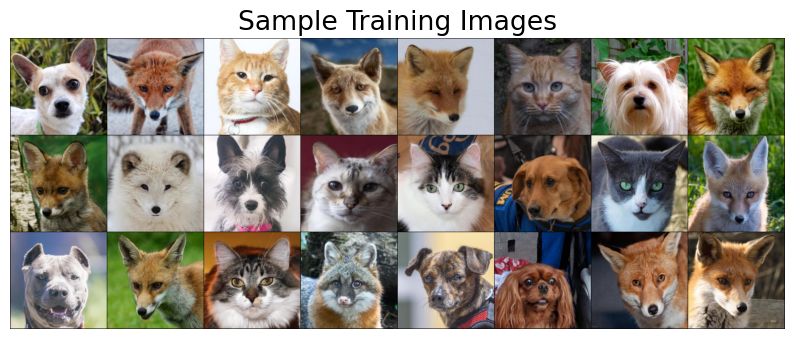

In [11]:
plot_sample_imgs(X_anim_train[0:24,:,:,:])

In [12]:
X_train.shape

(150, 3, 200, 200)

In [13]:
Z_train = get_features(
    densenet, X_anim_train, 
)

In [14]:
Z_train.shape

torch.Size([150, 1024])

In [15]:
Z_valid = get_features(
    densenet, X_anim_valid, 
)

In [16]:
Z_valid.shape

torch.Size([150, 1024])

In [17]:
from sklearn.dummy import DummyClassifier

dummy = DummyClassifier()
pd.DataFrame(cross_validate(dummy, Z_train, y_train, return_train_score=True))

,fit_time,score_time,test_score,train_score
0,0.005536,0.000855,0.333333,0.333333
1,0.000259,0.000223,0.333333,0.333333
2,0.000172,0.000212,0.333333,0.333333
3,0.000160,0.000306,0.333333,0.333333
4,0.000245,0.000231,0.333333,0.333333


In [18]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
pd.DataFrame(cross_validate(knn, Z_train, y_train, return_train_score=True))

,fit_time,score_time,test_score,train_score
0,0.000879,0.504612,0.966667,0.983333
1,0.000667,0.006129,0.933333,0.983333
2,0.000410,0.001978,0.966667,0.983333
3,0.000346,0.002258,0.933333,0.983333
4,0.000347,0.001965,1.000000,0.983333


This is with the default `n_neighbors`. Let's optimize `n_neighbors`. 

In [19]:
knn.get_params()['n_neighbors']

5

In [20]:
k_values = np.arange(1, 15, 1)
cv_scores = []
train_scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_validate(knn, Z_train, y_train, return_train_score=True)
    cv_scores.append(scores['test_score'].mean())
    train_scores.append(scores['train_score'].mean())    

In [21]:
results_df = pd.DataFrame({"cv": cv_scores, 
                           "train": train_scores},index = k_values)
results_df

,cv,train
1,0.960000,1.000000
2,0.953333,0.986667
3,0.973333,0.990000
4,0.960000,0.983333
5,0.960000,0.983333
6,0.946667,0.976667
7,0.946667,0.976667
8,0.933333,0.963333
9,0.940000,0.970000
10,0.906667,0.958333


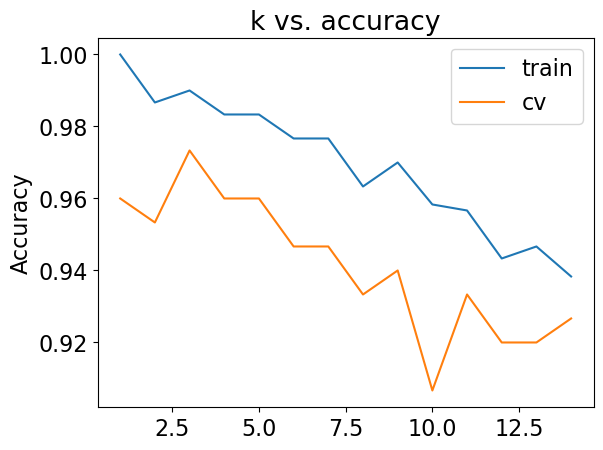

In [22]:
results_df[['train', 'cv']].plot(ylabel='Accuracy', title="k vs. accuracy");

In [23]:
best_k = k_values[np.argmax(results_df['cv'])]
best_k

3

Is SVC performing better than k-NN? 

In [25]:
C_values = np.logspace(-1, 2, 4)
cv_scores = []
train_scores = []

for C_val in C_values:
    print('C = ', C_val)
    svc = SVC(C=C_val)
    scores = cross_validate(svc, Z_train, y_train, return_train_score=True)
    cv_scores.append(scores['test_score'].mean())
    train_scores.append(scores['train_score'].mean())    

C =  0.1
C =  1.0
C =  10.0
C =  100.0


In [27]:
results_df = pd.DataFrame({"cv": cv_scores, 
                           "train": train_scores},index = C_values)
results_df

,cv,train
0.1,0.980000,0.995
1.0,0.993333,1.000
10.0,0.993333,1.000
100.0,0.993333,1.000


In [28]:
best_C = C_values[np.argmax(results_df['cv'])]
best_C

1.0

Much better CV accuracy with SVC compared to KNNs. `sklearn`'s default of `C=1` didn't give us the best cv scores. 

Let's go back to KNN and manually examine the nearest neighbours. 

What are the nearest neighbors?

In [29]:
from sklearn.neighbors import NearestNeighbors
nn = NearestNeighbors()
nn.fit(Z_train)

NearestNeighbors()

In [30]:
# You do not have to understand this code. 
def show_nearest_neighbors(test_idx, nn, Z, X, y):
    distances, neighs = nn.kneighbors([Z[test_idx]])
    neighbors = neighs.ravel()
    plt.figure(figsize=(2,2), dpi=80)
    query_img = X[test_idx].transpose(1, 2, 0)
    plt.title('Query image', size=12)
    plt.imshow(np.clip(query_img, 0, 255));
    plt.xticks(())
    plt.yticks(())    
    plt.show()
    
    fig, axes = plt.subplots(1, 5, figsize=(10,4), subplot_kw={'xticks':(), 'yticks':()})
    print('Nearest neighbours:')
    
    for ax, dist, img_ind in zip(axes.ravel(), distances.ravel(), neighbors):
        img = X_train[img_ind].transpose(1, 2, 0)
        ax.imshow(np.clip(img, 0, 255))
        ax.set_title('distance: '+ str(round(dist,3)), size=10 )
    plt.show()

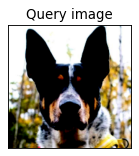

Nearest neighbours:


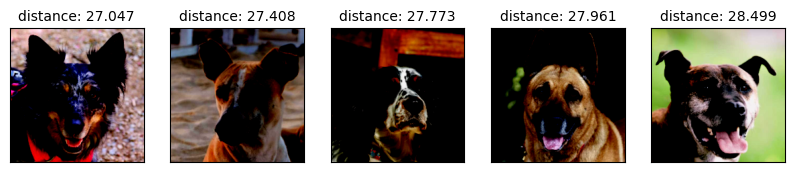

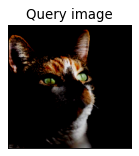

Nearest neighbours:


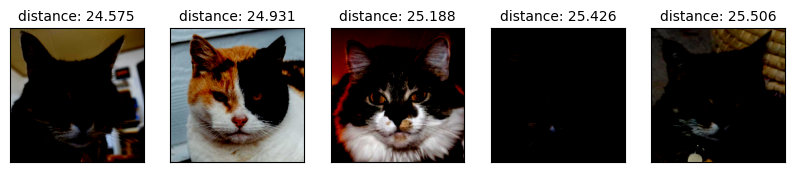

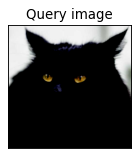

Nearest neighbours:


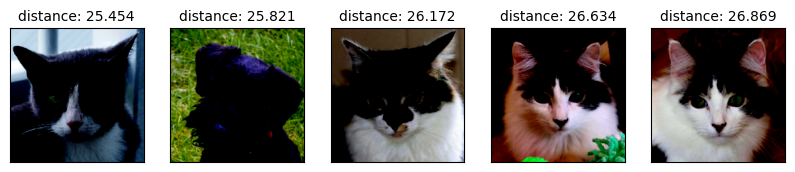

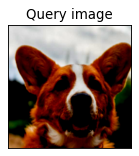

Nearest neighbours:


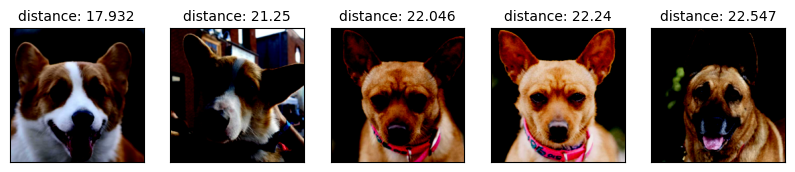

In [31]:
test_idx = [6, 32, 78, 3]
for idx in test_idx: 
    show_nearest_neighbors(idx, nn, Z_valid, X_valid, y_valid)